# Load in previously trained Logistic Regression model and classify unknown samples

In [26]:
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import numpy as np
#from itertools import combinations
import sys
import importlib

sys.path.append('../../scripts/')
# Contains special functions used in the script 
import GeochemFunctions as geofctns
importlib.reload(geofctns)

import GeochemPlotting as geoplots
importlib.reload(geoplots)

!pwd

/Users/leif/gitrepos/learngeochem/notebooks/Hampton_CRB


In [27]:
#Data subsets 
#D1 is major elements only 
#D2 maximizes samples (covers every assumed member)
#D3 maximizes elements (not every member covered)

##Classify at formation level
# filename = 'CRB_Formation_level_model_D2.pkl'
# datalabelname = 'CRB_Formation_labels_D2.pkl'
# classlabels = 'FormationLookupTable.pkl'

###Classify at member
filename = 'CRB_Member_level_model_D2.pkl'
datalabelname = 'CRB_Member_labels_D2.pkl'
classlabels = 'MemberLookupTable_D2.pkl'

featurelabels = 'TrainingDataFeatures_D2.pkl'

# load the model from disk
CRB_model = pickle.load(open(filename, 'rb'))

CRB_feature_labels = pickle.load(open(datalabelname, 'rb'))
CRB_class_labels = pickle.load(open(classlabels, 'rb'))

trainingdata_labels = pickle.load(open(featurelabels, 'rb'))

strs=np.where(np.isin(trainingdata_labels, ['Formation', 'Member',  'MemberID', 'Source', 'FormationID', 'Polarity']))
#print(strs)
trainingdata_labels = np.delete(trainingdata_labels, strs)

print(trainingdata_labels)
print(CRB_class_labels)
CRB_feature_labels

['SiO2' 'TiO2' 'Al2O3' 'MnO' 'MgO' 'CaO' 'Na2O' 'K2O' 'P2O5' 'Ni' 'Cr'
 'Sc' 'V' 'Ba' 'Rb' 'Sr' 'Zr' 'Y' 'Nb' 'Cu']
    MemberID            Member  NumSamples
0          0       LowerSteens          78
1          1       UpperSteens          32
2          2          LogCreek          20
3          3         FallCreek           8
4          4       AmericanBar          99
5          5         RockCreek          68
6          6      PictureGorge         138
7          7   BuckhornSprings          20
8          8        BirchCreek          38
9          9       TeepeeButte          31
10        10        Rogersburg          23
11        11     SkeletonCreek          38
12        12       CenterCreek          10
13        13      KendrikGrade          27
14        14        BradyGulch          21
15        15       DowneyGulch          59
16        16         FryePoint          17
17        17        ChinaCreek          40
18        18       HoskinGulch          56
19        19  ColdSpring

0        0
89       0
88       0
87       0
86       0
        ..
9440    46
9443    46
9444    46
9441    46
9442    46
Name: MemberID, Length: 4600, dtype: int64

## Load the data we want to classify here

(1562, 37)
['SiO2' 'TiO2' 'Al2O3' 'MnO' 'MgO' 'CaO' 'Na2O' 'K2O' 'P2O5' 'Ni' 'Cr'
 'Sc' 'V' 'Ba' 'Rb' 'Sr' 'Zr' 'Y' 'Nb' 'Cu']
(1561,)
dataframe is all numeric: True
    SiO2  TiO2  Al2O3   MnO   MgO   CaO  Na2O   K2O  P2O5    Ni    Cr    Sc  \
0  51.15  1.82  13.76  0.22  5.07  8.95  2.65  0.72  0.26  13.0  36.0  35.0   
1  51.15  1.82  13.76  0.22  5.07  8.95  2.65  0.72  0.26  13.0  36.0  35.0   

       V     Ba    Rb     Sr     Zr     Y    Nb    Cu  
0  326.0  375.0  21.0  321.0  154.0  33.0  12.0  37.0  
1  326.0  375.0  21.0  321.0  154.0  33.0  12.0  37.0  
(1561, 20)


(array([  57.,    0.,   95.,    0.,    0.,    0., 1121.,    0.,  100.,
         188.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

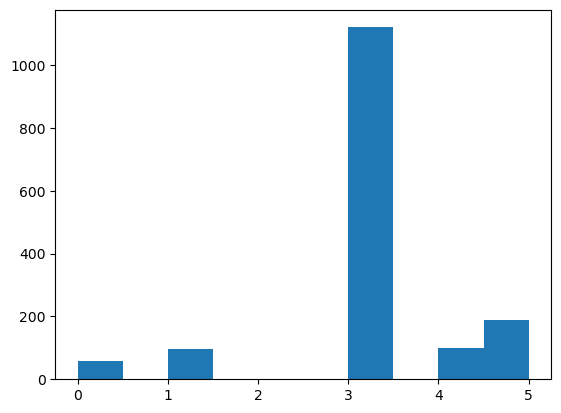

In [28]:
#CRB database that we want to classify
#datafile = '/Users/leif/gitrepos/learngeochem/data/CRB/HamptonThesis_S1DikeGeochemicalData.csv'
#datafile = '/Users/leif/gitrepos/learngeochem/data/CRB/CRB_undifferentiated_2025_forpaper.csv'
#datafile = '/Users/leif/gitrepos/learngeochem/data/CRB/HughesDataAll_2024.csv'

datapath = '/Users/leif/gitrepos/learngeochem/data/CRB/'

datafile = datapath+'CRB_undifferentiated_2025_updated.csv'

mx_data_=pd.read_csv(datafile, header=0)

mx_data_.dropna(subset=['FormationID'], inplace=True)

#mx_data_ = mx_data_.dropna()
print(np.shape(mx_data_))
#print(mx_data_.head(2))
print(trainingdata_labels)
#drop columns to match the training dataset
mx_features_ = mx_data_[trainingdata_labels]
mx_formationID = mx_data_['FormationID']
mx_source = mx_data_['Source']


#do some processing to make sure all the numbers will play well with subsequent processing
#print(trainingdata_labels)

#mx_features_.drop(columns=['Formation','FormationID'])
#print(mx_features_)

# Drop rows where the value in a column is zero
mx_features_ = mx_features_[mx_features_ != 0]
mx_features_=mx_features_.astype(float)
# Round all columns to 2 decimal places
mx_features_ = mx_features_.round(2)

# Identify rows with NaN values
null_mask = mx_features_.isnull().any(axis=1)

# Get the indices of dropped rows
dropped_indices = null_mask[null_mask].index


mx_features_ = mx_features_.dropna(axis=0, how='any')

mx_formationID = mx_formationID.drop(dropped_indices)
mx_source = mx_source.drop(dropped_indices)
print(np.shape(mx_formationID))

#double check that this dataframe is all numeric values
numeric_df = mx_features_.apply(pd.to_numeric, errors='coerce')
is_all_numeric = not numeric_df.isnull().values.any()
print('dataframe is all numeric: ' + str(is_all_numeric))
# Find rows with NaN values
#rows_with_non_numbers = mx_features_[numeric_df.isna().any(axis=1)]

print(mx_features_.head(2))
print(np.shape(mx_features_))
plt.hist(mx_formationID)

In [29]:
#standard naming
df2 = mx_features_

df2.drop_duplicates()

#make ratios between every feature and every other feature  
df2 = pd.DataFrame(geofctns.makeratios(df2))

#power transform to normalize values
df2 = geofctns.normalizedata(df2,'powert')

print(np.shape(df2))

(1561, 210)


In [30]:
#make classification prediction using trained model
unknown_data = df2

#make a prediction based on highest probability for each sample
prediction=CRB_model.predict(unknown_data)

# Loop over prediction vector to find the labels 
matching_rows = []
for val in prediction:
    CRB_class_labels.loc[CRB_class_labels['MemberID'] == val, 'Member'].item()
    matching_rows.append(CRB_class_labels.loc[CRB_class_labels['MemberID'] == val, 'Member'].item())
    # CRB_class_labels.loc[CRB_class_labels['FormationID'] == val, 'Formation'].item()
    # matching_rows.append(CRB_class_labels.loc[CRB_class_labels['FormationID'] == val, 'Formation'].item())    

prediction=pd.DataFrame({'ID': prediction, 'label': matching_rows})
                  
probability=CRB_model.predict_proba(unknown_data)
probability=pd.DataFrame(probability) 
probability.columns = CRB_class_labels.Member

#Clean up the probabilities by setting any probability < threshold equal to zero
lowerLimit = .01

#we will set any value less than 'lowerlimit' to zero for ease in visualization. 
probability_clean = probability.copy()
probability_clean[probability_clean<lowerLimit]=0

#print(PredictedName)
#print(matching_rows)  
print(probability)
print(probability_clean)

Member   LowerSteens   UpperSteens      LogCreek     FallCreek   AmericanBar  \
0       1.145399e-08  1.205116e-05  1.379088e-08  9.655606e-07  9.490859e-04   
1       1.145399e-08  1.205116e-05  1.379088e-08  9.655606e-07  9.490859e-04   
2       9.423417e-10  1.065037e-07  4.985261e-10  2.016412e-06  3.386061e-05   
3       9.423417e-10  1.065037e-07  4.985261e-10  2.016412e-06  3.386061e-05   
4       1.898817e-07  4.809510e-05  1.899667e-09  6.189605e-06  4.472298e-06   
...              ...           ...           ...           ...           ...   
1556    8.244713e-10  1.342750e-08  1.870967e-10  2.648541e-10  1.671038e-08   
1557    6.416519e-09  8.259937e-09  2.121015e-09  4.468179e-08  4.064575e-05   
1558    5.520080e-09  1.200572e-08  5.406747e-10  8.300556e-09  4.542926e-07   
1559    2.001195e-08  3.811194e-09  1.747212e-09  8.150099e-08  4.097437e-05   
1560    2.967253e-07  3.397993e-11  2.378440e-09  1.299954e-14  1.913301e-15   

Member     RockCreek  PictureGorge  Buc

## Plotting 

Do this in two stages - we want to look both at individual samples to see the spread in probabilities and then at a group of samples

In [31]:
#first, redefine the generic dataframe df to be associated with output from classified
df = probability_clean#probability

#pick a sample to plot
n=10
data = np.array(df.iloc[n,:].values)

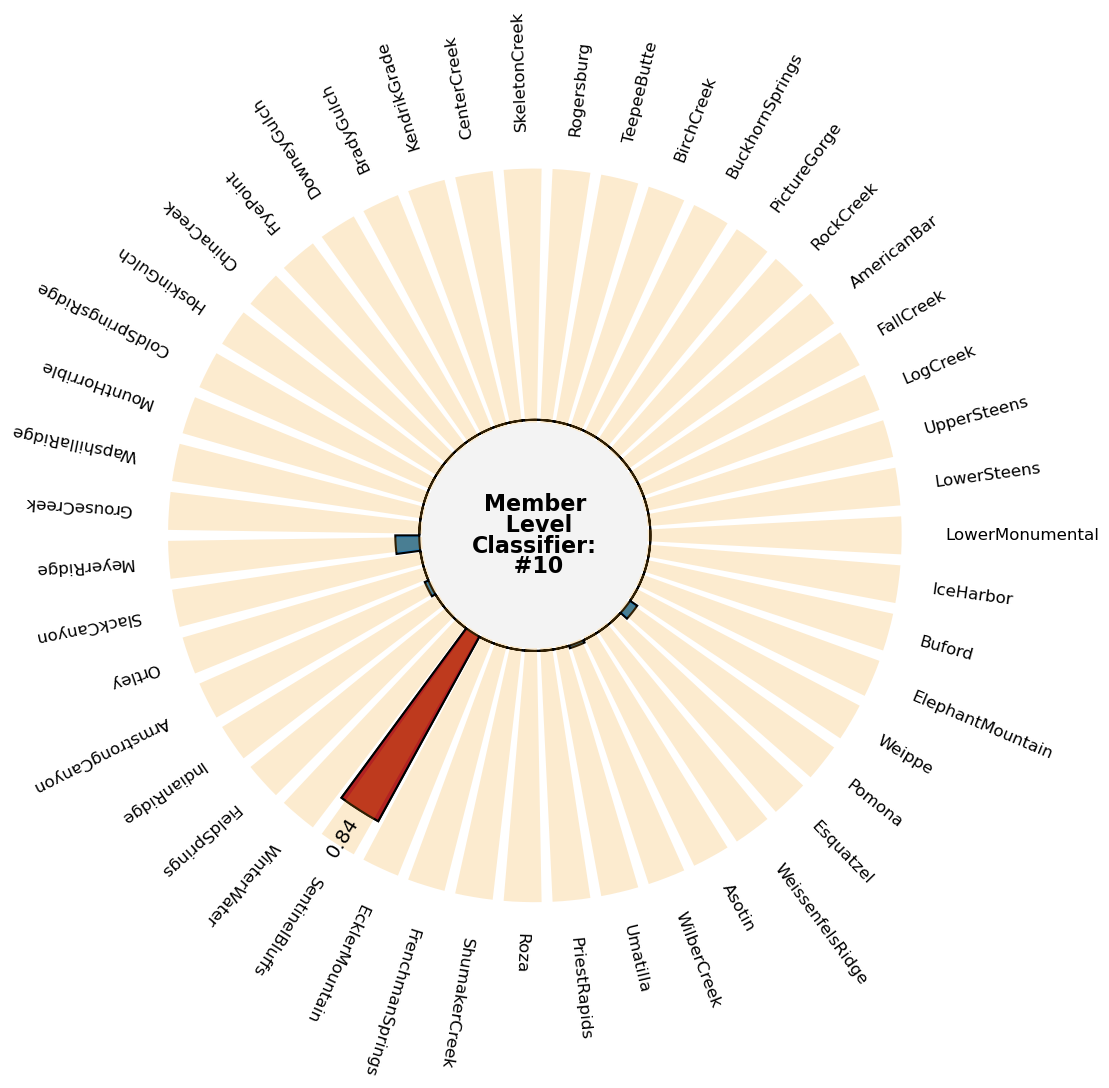

In [32]:
#single panel plot for one sample
fig=plt.figure(figsize=(10,10))

    # plot polar axis
ax = plt.subplot(111, polar=True)

#sample = df['Sample'][n]
centerlabel="Member\n Level\nClassifier:\n #" + str(n)  
classlabels = CRB_class_labels.Member

geoplots.plot_single_classification(data,classlabels,fig,ax,centerlabel,12,lowerLimit)
#plt.savefig('GoodClassify.pdf')

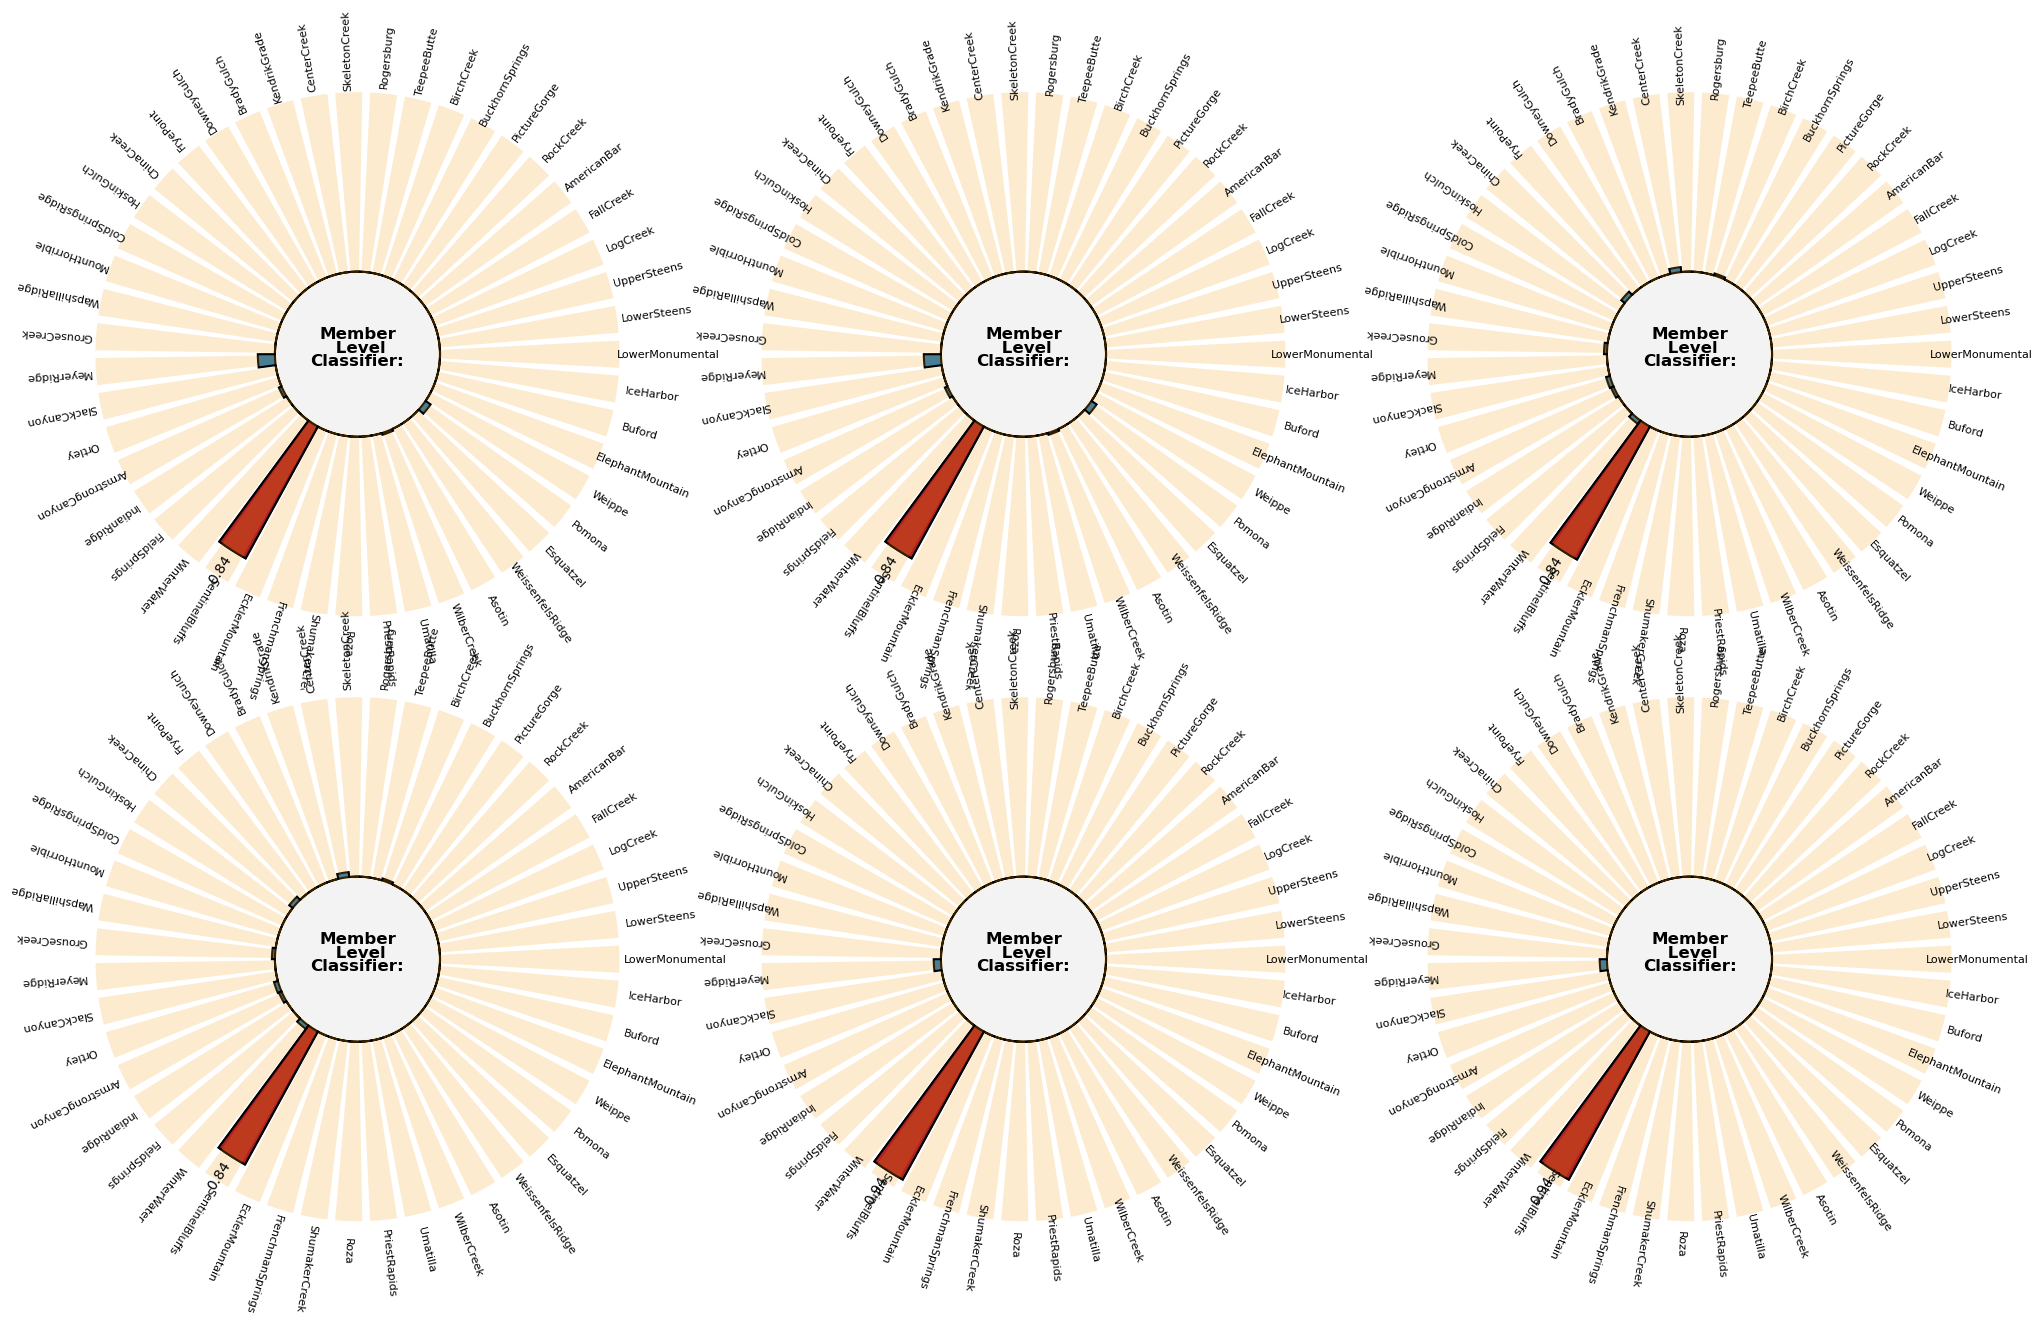

In [33]:
#multiple panel plot
nrow = 2
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(25, 15), subplot_kw={"projection": "polar"})
fig.patch.set_facecolor("white")

# Define the slices used to iterate through 'axes'.
# It iterates in a rowwise manner.
# It starts in the first row, and iterates over all the columns of that row
# from left to right, then it goes to the next row and does the same.
SLICES = [(i, j) for i in range(nrow) for j in range(ncol)]

#generate list of indices to call from our dataframe of classified samples
#total length needs to be equal to or greater than nrow*ncol
lower=10
upper=64
nidx = [i for i in range(lower,upper)]

for slice_ in SLICES:
    # Select axis
    ii = (slice_[1]+1) + ncol*slice_[0]
    
    ax = axes[slice_[0],slice_[1]]
    
    # Select indexes corresponding to the passwords in this category
    #test dataset
    n=nidx[ii-1]
    
    data = np.array(df.iloc[n,:].values)

    # Set the coordinates limits
    #upperLimit = 1
    lowerLimit = .01

    #we will set any value less than 'lowerlimit' to zero for ease in visualization. 
    data[data<lowerLimit]=0
    
    #sample number label
    centerlabel="Member\n Level\nClassifier:\n"  
    classlabels = CRB_class_labels.Member
    
    geoplots.plot_single_classification(data,classlabels,fig,ax,centerlabel,8,lowerLimit)
       
# Adjust space between subplots.
# 'wspace=0' leaves no horizontal space between subplots.
# 'hspace=0' leaves no vertical space between subplots.
fig.subplots_adjust(wspace=0.1, hspace=0.1)

## Plot up the distribution of classifications for many samples

In [34]:
maxprob = []#np.empty([df.shape[0]])
matchedprob = []
classmax = []#np.empty([df.shape[0]])
classmatched = []
secondlargest = []
secondlargestclass = []
thirdlargest = []
thirdlargestclass = []

maxprob_nm = []
class_nm = []

for i in range(0,df.shape[0]):
    
    data = np.array(df.iloc[i,:].values)

    maxprobb = np.amax(data) #most likely classification, above threshold
    idx = np.argmax(data) #where in the array this occurs   
    
    classthresh = 0.75 #threshold for match
    nthresh = 0.01 #threshold probability to consider 
    
    datasort = np.abs(np.sort(-data)) #sort from largest to smallest
    sorted_indices = np.argsort(-data)
    
    if np.amax(data)>classthresh:
        match = np.amax(data) #most likely classification, above threshold
        idxmatch = np.argmax(data) #where in the array this occurs
        
        matchedprob.append(match)
        classmatched.append(idxmatch)
    else:
        match_nm = np.amax(data)
        idxmatch_nm = np.argmax(data) 
        maxprob_nm.append(match_nm)
        class_nm.append(idxmatch_nm)
        
    secondmax = np.amax(datasort[1])
    idx2 = np.amax(sorted_indices[1])
    thirdmax = np.amax(datasort[2])
    idx3 = np.amax(sorted_indices[2])

    #q90, q50 = np.percentile(data[data>nthresh], [90 ,50])
    #q3, q1 = np.percentile(data[data>nthresh], [75 ,25])
    #iqr = q3 - q1 #interquartile range of probabilities
        
    maxprob.append(maxprobb)
    
    classmax.append(idx)

    secondlargest.append(secondmax)
    secondlargestclass.append(idx2)
    thirdlargest.append(thirdmax)
    thirdlargestclass.append(idx3)

print('We have unambiguously classified ' + str(len(matchedprob)) + ' out of ' + str(len(maxprob)) + ' samples!!')
print('Threshold for classification is ' + str(classthresh) + ' probability.')


We have unambiguously classified 893 out of 1561 samples!!
Threshold for classification is 0.75 probability.


In [97]:
probarray = np.array([classlabels[classmax],maxprob,classlabels[secondlargestclass],secondlargest,classlabels[thirdlargestclass],thirdlargest])
df1 = pd.DataFrame(probarray.T, columns=['Highest Prob Member', 'Probability', '2nd Highest Prob Member','Probability', 'Third Highest Prob Member','Probability'])
df1.head(5)
df1.to_csv('MLR_Probabilities_Undifferentiated_D2_Formation.csv')

In [12]:
#now bin these into distributions 
#histmax, bin_edgesmax = np.histogram(classmax,bins=len(GRBname))

maxmean=[]
max_nm_mean=[]
firstmean = []
secmean = []
thirdmean = []
histmax=[]
histfirst=[]
histsecond=[]
histthird=[]
hist_nm = []

#compute the stats of probability per class
for jj in range(0,len(classlabels)):
    
    maxsub = geofctns.find(classmatched,matchedprob,jj)#(classmax,maxdat,jj)
    maxnm = geofctns.find(class_nm,maxprob_nm,jj)
    
    first = geofctns.find(classmax,maxprob,jj)
    second = geofctns.find(secondlargestclass,secondlargest,jj)
    third = geofctns.find(thirdlargestclass,thirdlargest,jj)
    
    #max_nmsub = geofctns.find(classmax,mean_nm,jj) 
    histmx = geofctns.find(classmatched,[],jj)
    
    histmx_nm = geofctns.find(class_nm,[],jj)
    histfrst = geofctns.find(classmax,[],jj)
    histsec = geofctns.find(secondlargestclass,[],jj)
    histthrd = geofctns.find(thirdlargestclass,[],jj)
    
    if len(maxsub) > 0:   
        histmax.append(len(histmx))
        maxmean.append(np.mean(maxsub))
        max_nm_mean.append(len(histmx_nm))#np.mean(maxnm))
    else:
        histmax.append(0)
        maxmean.append(0)
        max_nm_mean.append(0)
    if len(first) > 0:
        histfirst.append(len(histfrst))
        firstmean.append(np.median(first))
    else:
        histfirst.append(0)
        firstmean.append(0)
    if len(second) > 0:
        histsec.append(len(histsec))
        secmean.append(np.median(second))
    else:
        histsec.append(0)
        secmean.append(0)
    if len(third) > 0:
        histthird.append(len(histthrd))
        thirdmean.append(np.median(third))
    else:
        histthird.append(0)
        thirdmean.append(0)
        
        # histfirst.append(0)        
        # histsecond.append(len(histsec))
        # histthird.append(len(histthrd))
        
        #histmax.append(len(histmx))
        maxmean.append(np.mean(maxsub))
        #max_nm_mean.append(np.mean(max_nmsub))
    # else:
    #     histmax.append(0)
    #     histsecond.append(0)
    #     histthird.append(0)
    #     maxmean.append(0)
    #     #max_nm_mean.append(0)

print(histmax)

print(firstmean)
print(np.shape(histmax),np.shape(y))

[2, 1, 0, 2, 19, 67, 14, 10, 2, 6, 2, 1, 7, 26, 0, 0, 0, 7, 0, 0, 1, 143, 0, 93, 0, 1, 0, 0, 29, 30, 221, 16, 26, 8, 2, 47, 29, 4, 36, 7, 0, 3, 4, 9, 2, 13, 3]
[0.8054159576374058, 0.5569318937709795, 0.6739028235761577, 0.5653668685647385, 0.7059337730562318, 0.9999879683101796, 0.8756454879014761, 0.4355009312322149, 0.44179766090656625, 0.6280073388983799, 0.4658002687980107, 0.46307910330559043, 0.5086664448175622, 0.8876156898157402, 0, 0.35558621269107443, 0.4312645645931301, 0.7443001836365915, 0.3654823820882444, 0.3777393338205814, 0.44248110547350267, 0.8329765642286648, 0.36107006070246883, 0.9758717380312274, 0, 0.6120319442403148, 0.4683491225415656, 0, 0.9825674491483716, 0.6532455317405097, 0.8054940889512882, 0.9322696277026008, 0.6507074424940569, 0.9994392060563485, 0.5233726404382836, 0.9512179201591937, 0.9999935483547564, 0.9935570119336161, 0.9810146531521127, 0.922562835574104, 0.7133290239775435, 0.9815230048231063, 0.99931409028666, 0.5696541189014444, 0.809604

/Users/leif/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/leif/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


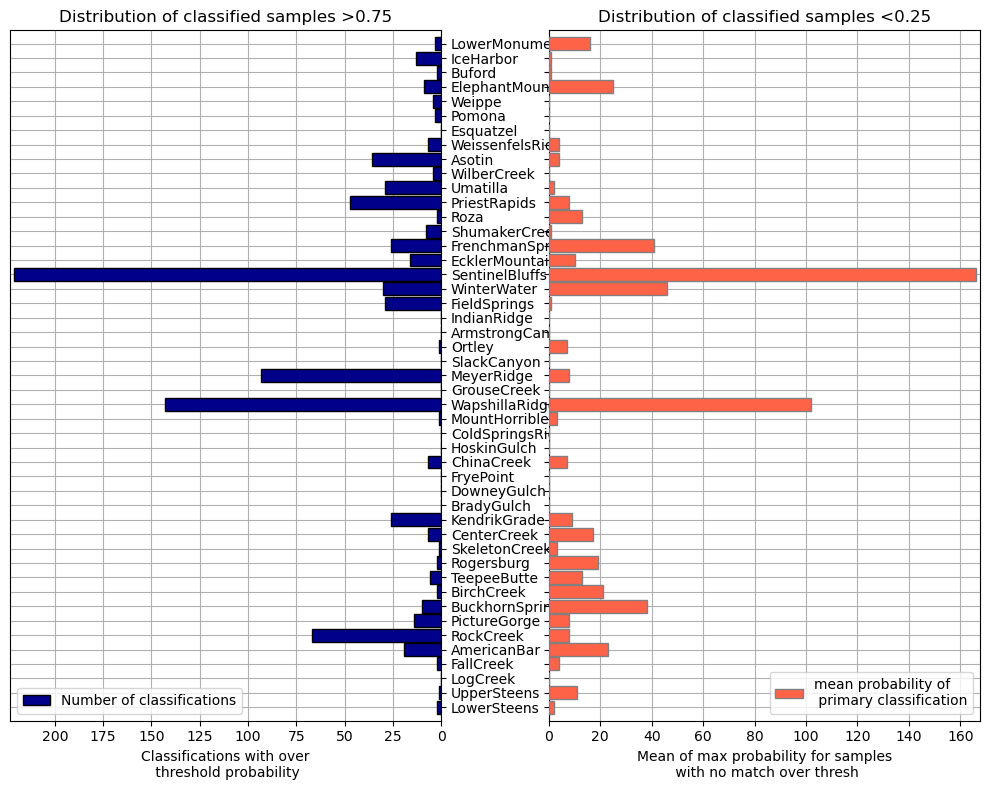

In [13]:
y = np.arange(np.array(histmax).size)
#y2 = np.arange(np.array(histmx_nm).size)

Leg = ['mean(max\n probabilities in class)','mean(non-max\n probabilities in class)']

fig, axes = plt.subplots(ncols=2, sharey=True,figsize=(10, 8))
axes[0].barh(y, histmax,0.9, align='center', color='darkblue', zorder=10, edgecolor="black",label='Number of classifications')
axes[0].set(xlabel='Classifications with over\n threshold probability')
axes[0].legend(loc='lower left')
axes[0].set(title='Distribution of classified samples >0.75')
              
axes[1].barh(y, max_nm_mean,0.9, align='center', color='tomato', zorder=10,edgecolor="gray",label='mean probability of\n primary classification')
#axes[1].plot(max_nm_mean,y,'k--',zorder=10,label='mean probability of\n other possible categories')
axes[1].set(xlabel='Mean of max probability for samples\n with no match over thresh')
axes[1].legend(loc='lower right')
axes[1].set(title='Distribution of classified samples <0.25')

#axes[1].set_xlim([0 ,1])

axes[0].invert_xaxis()
axes[0].set(yticks=y, yticklabels=classlabels)
axes[0].yaxis.tick_right()

for ax in axes.flat:
    ax.margins(.01)
    ax.grid(True)

fig.tight_layout()
fig.subplots_adjust(wspace=0.25)
#plt.show()
#fig.savefig('Classification_Distribution_probs.pdf')

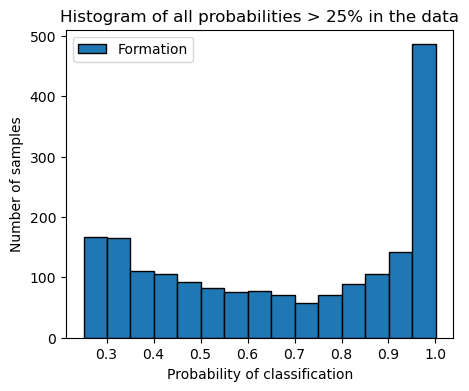

In [14]:
# Plot histogram along the x-axis (first column)
DD = df.values[df.values>1-classthresh]

plt.figure(figsize=(5,4))
#plt.hist([DD, DD2],bins = np.arange( min( DD )  , 1.01 , .05 ) , edgecolor="k", label=['Formation','member'] )
plt.hist(DD,bins = np.arange( min( DD )  , 1.01 , .05 ) , edgecolor="k", label=['Formation','member'] )
plt.xlabel('Probability of classification')
plt.ylabel('Number of samples')
plt.title("Histogram of all probabilities > 25% in the data")
plt.legend()
#plt.show()
#plt.savefig('UnknownProbs.pdf')

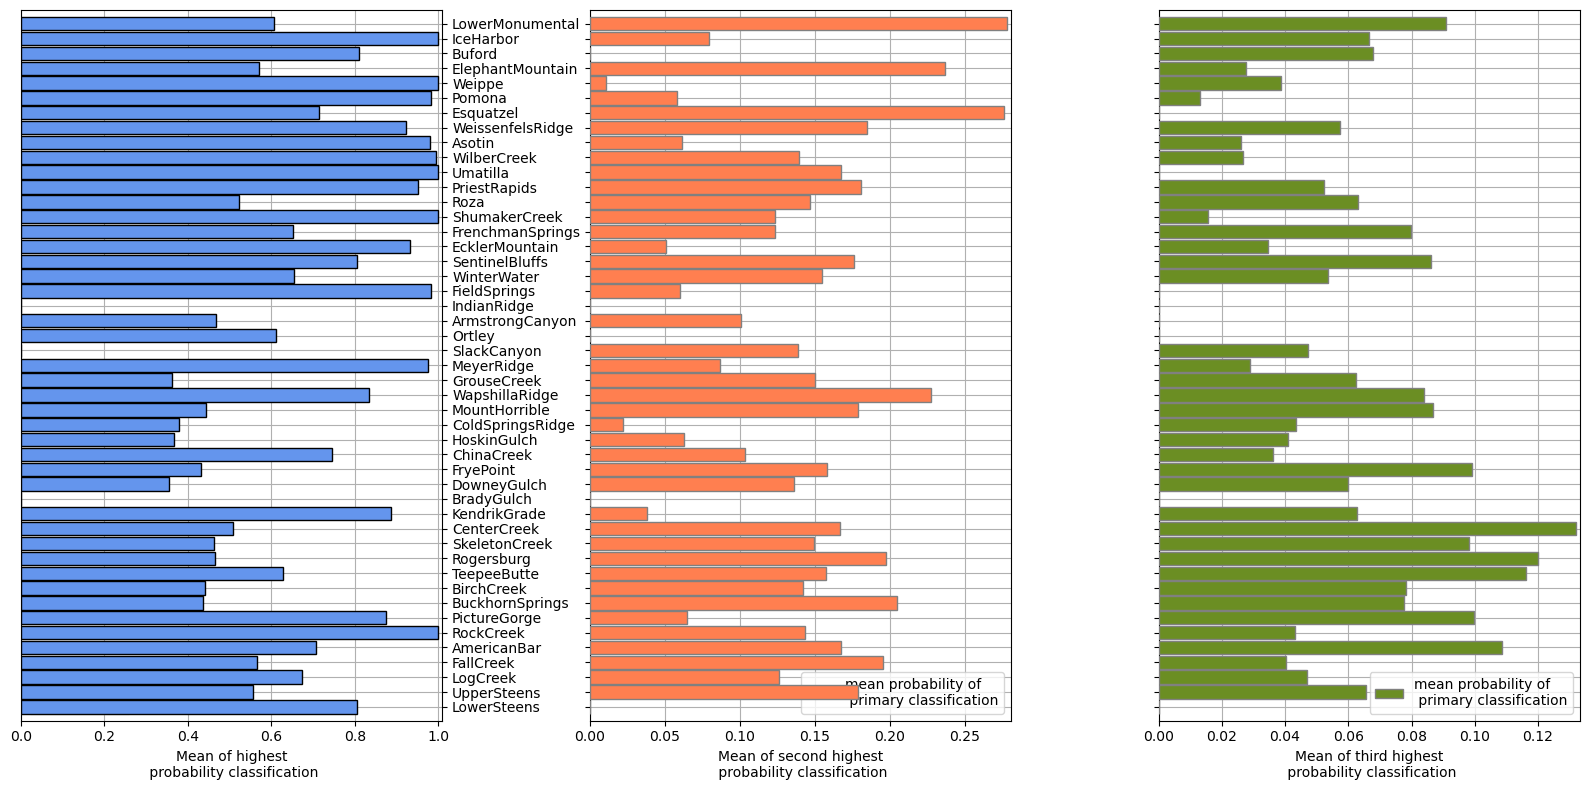

In [15]:
y = np.arange(np.array(firstmean).size)

fig, axes = plt.subplots(ncols=3, sharey=True,figsize=(16, 8))
axes[0].barh(y, firstmean,0.9, align='center', color='cornflowerblue', zorder=10, edgecolor="black",label='Highest')
axes[0].set(xlabel='Mean of highest\n probability classification')
axes[0].legend(loc='lower left')

axes[1].barh(y, secmean,0.9, align='center', color='coral', zorder=10,edgecolor="gray",label='mean probability of\n primary classification')
#axes[1].plot(max_nm_mean,y,'k--',zorder=10,label='mean probability of\n other possible categories')
axes[1].set(xlabel='Mean of second highest\n probability classification')
axes[1].legend(loc='lower right')

axes[2].barh(y, thirdmean,0.9, align='center', color='olivedrab', zorder=10,edgecolor="gray",label='mean probability of\n primary classification')
#axes[2].plot(max_nm_mean,y,'k--',zorder=10,label='mean probability of\n other possible categories')
axes[2].set(xlabel='Mean of third highest\n probability classification')
axes[2].legend(loc='lower right')


#axes[0].invert_xaxis()
axes[0].set(yticks=y, yticklabels=classlabels)
axes[0].yaxis.tick_right()

axes[2].set(yticks=y, yticklabels=classlabels)
#axes[1].yaxis.tick_right()

for ax in axes.flat:
    ax.margins(.01)
    ax.grid(True)

fig.tight_layout()
fig.subplots_adjust(wspace=0.35)
#fig.savefig('Classification_Distribution2.pdf')

In [24]:
MatchedData = df[(df.values > classthresh).any(axis=1)]
NonMatch = df[~df.isin(MatchedData)].dropna()

NumPoss = []
NonMatchClassList = {}
ClassNums = []
ProbArray = []
#now compute the stats of probability per class for non-matched data
for i in range(0,NonMatch.shape[0]):
    data = np.array(NonMatch.iloc[i,:].values)
    
    #find the number of possible classifications per sample
    ProbN = data[data > 1-classthresh]
    NumPoss.append(np.sum(data> 1-classthresh))
    idxp = np.argwhere(data> 1-classthresh) #where in the array this occurs   

    datasort = np.abs(np.sort(-NonMatch)) #sort from largest to smallest
    sorted_indices = np.argsort(-NonMatch)
    classesidx = classlabels[idxp.flatten()]
    if len(idxp.flatten())>1:
        ClassNums.append(idxp.flatten())
    
        #make a dictionary 
        classdata = {'num': i, 'member': classesidx, 'prob': ProbN}
        NonMatchClassList[i] = classdata
        
        #make array of only probabilities > 1-classthresh and append for plotting
        datac=data
        datac[data < 1-classthresh]=0
        ProbArray.append(datac)
    
# plt.hist(NumPoss ,  edgecolor="k" )
# plt.show()

#print(len(classlabels),NonMatch.shape[0],np.shape(ProbArray))

print('There are ' + str(np.shape(ProbArray)[0]) + ' samples that have at least 2 classifications above ' + str(1-classthresh))


print('There are ' + str(NonMatch.shape[0]-np.shape(ProbArray)[0]) + ' samples that have a single classification below ' + str(classthresh))

print('We will call these ambiguously classified')

len(NonMatch)

There are 334 samples that have at least 2 classifications above 0.25
There are 334 samples that have a single classification below 0.75
We will call these ambiguously classified


668

# Plot the samples that have probability > (1 - thresh in more than one class

(334, 47)


/var/folders/sc/l94184295fdfnlyrwdthmhwc0000gq/T/ipykernel_9355/263489087.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(classlabels)


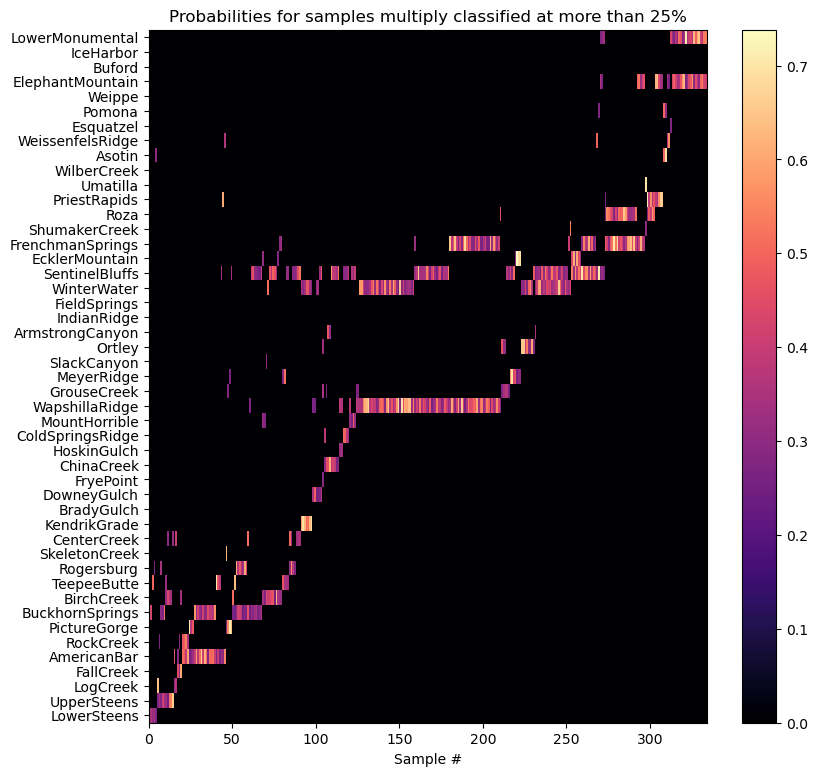

In [17]:
print(np.shape(ProbArray))

# Sort rows based on the position of first nonzero indices
sorted_arr = np.array(sorted(ProbArray, key=lambda x: tuple(x!=0), reverse=True))

y = np.arange(ProbArray[0].size)

# Create the plot
fig, ax = plt.subplots(figsize=(9, 9))
im = ax.pcolormesh(sorted_arr.transpose(), cmap='magma')

# Set the yticklabels
ax.set_yticklabels(classlabels)
ax.set_yticks(np.arange(len(classlabels))+0.5)
#ax.grid(True, color='white', linestyle='-')

ax.set(title='Probabilities for samples multiply classified at more than 25%')
ax.set(xlabel='Sample #')
fig.colorbar(im, ax=ax)  

#plt.show()
plt.savefig('MultiplyClassified_HeatMapFig.pdf')

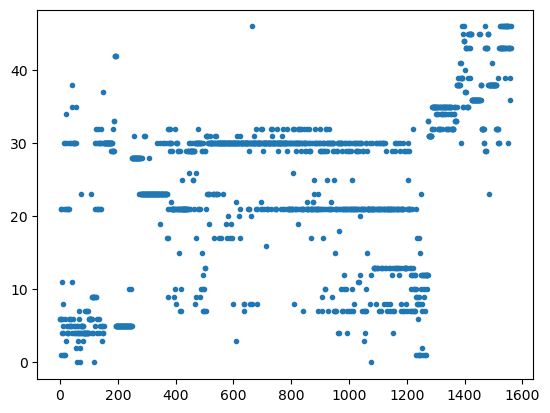

In [18]:
plt.plot(np.argmax(CRB_model.predict_proba(unknown_data),1),'.')

In [20]:
predvals=np.argmax(CRB_model.predict_proba(unknown_data),1)
cond=(np.amax(CRB_model.predict_proba(unknown_data),1)>.75)


combined_array = np.column_stack((predvals[cond], mx_formationID[cond]))


#np.savetxt("formation_predictions.csv", combined_array, delimiter=",",fmt='%d')

#mx_source.to_csv('sources.csv', index=False, encoding='utf-8')

np.shape(combined_array)

(893, 2)

In [307]:
IDXm=predvals#[cond]
c1=IDXm>2
c2=IDXm<6
c3=IDXm>6
c4=IDXm<31
c5=IDXm>30
c6=IDXm<36
Form = np.empty(len(IDXm))
for i in range(len(IDXm)):
    if IDXm[i]<2:
        Form[i] = 0
    elif IDXm[i]<6:
        Form[i] = 1
    elif IDXm[i]==6:
        Form[i] = 2
    elif IDXm[i]<31:
        Form[i] = 3
    elif IDXm[i]<36:
        Form[i] = 4
    elif IDXm[i]>35:
         Form[i] = 5
    

print(np.sum(IDXm<2),len(IDXm[c1 & c2]),np.sum(IDXm==6),len(IDXm[c3 & c4]),len(IDXm[c5 & c6]),np.sum(IDXm>35))

combined_array = np.column_stack((predvals[cond], mx_formationID[cond], Form[cond]))

print(np.shape(combined_array))
      
(len(mx_formationID)-(34-20 + 122-110 + 95-23 + 1121-1066 + 148-100 + 188-135))/len(mx_formationID)


113 1406 0 0 0 0
(1293, 3)


0.8372837924407431

0.9160035366931919


(array([[  3.,  58.,  19., 755., 118., 178.],
        [ 27.,  43.,   0., 802.,  99., 160.]]),
 array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
        4.16666667, 5.        ]),
 <a list of 2 BarContainer objects>)

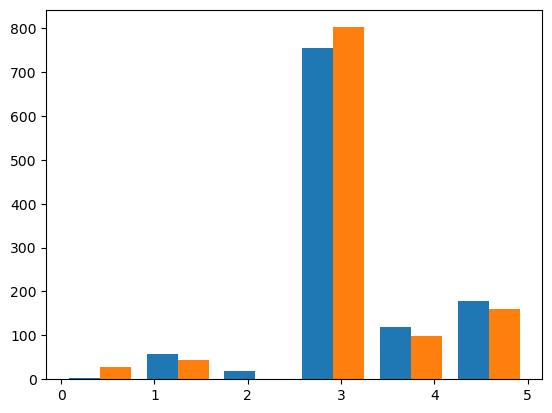

In [380]:
print(np.sum(combined_array[:, 0] == combined_array[:, 1])/len(mx_formationID[cond]))
plt.hist([combined_array[:,0],combined_array[:,1]],bins=6)


array([[21.,  3.,  3.],
       [21.,  3.,  3.],
       [21.,  3.,  3.],
       ...,
       [17.,  3.,  3.],
       [30.,  3.,  3.],
       [30.,  3.,  3.]])